In [13]:
# from google.colab import drive
# drive.mount('/content/drive')  # use this if you are using google colab

In [14]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import pickle, os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Dict, List, Tuple
from scipy.special import comb
import pprint

In [15]:
def load_dataset(name_file):

    desired_directory = '.' # Replace with your desired directory path

    file_path = os.path.join(desired_directory, name_file) 

    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f)

    return data_dict


In [16]:
loaders_dict = load_dataset(f"dataset-flowers102-features.pkl")
x_train = loaders_dict["x_train"]
x_test = loaders_dict["x_test"]
y_train = loaders_dict["y_train"]
y_test = loaders_dict["y_test"]

## clustering images

In [17]:
k_number = 50
kmeans = KMeans(n_clusters=k_number)
clusters = kmeans.fit_predict(x_train)
centroids = kmeans.cluster_centers_ # (50, 512) <class 'numpy.ndarray'>

c:\Users\ewint\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [18]:
def rand_index_score(clusters, classes) -> float:
    """
    Calculate the Rand Index for two clusterings.
 
    The Rand Index is a measure of the similarity between two data clusterings. 
    It's calculated based on the number of pairs of elements that are in the same
    cluster in both the predicted and actual clusterings, and the number of pairs
    of elements that are in different clusters in both the predicted and actual clusterings.

    Parameters:
    clusters (array-like): The predicted cluster labels.
    classes (array-like): The actual class labels.

    Returns:
    float: The Rand Index score, a value between 0 and 1. A higher value indicates a better
    agreement between the predicted and actual clusters.
    """
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

rand_index = rand_index_score(clusters, y_train)
print('Rand Index:', rand_index)

Rand Index: 0.9803288729992978


## find nearest clusters neighbors

### find nearest clusters and their indices

In [19]:
def find_nearest_clusters_neighbors(x_train, x_test, k) -> np.ndarray:
    """ 
    Find k cluster(s) near data `x_test`.
    
    Parameters:
    k : int
    Number of neighbors to use.
       
    Returns:
    nearest_indices : ndarray of shape (n_queries, k)
        Indices of the nearest neighbors in the training set.
    """
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(x_train, range(len(x_train)))
    nearest_indices = knn_classifier.kneighbors(x_test, n_neighbors=k, return_distance=False)

    return nearest_indices

### get the data of nearest clusters

In [20]:
def gather_clusters_data(k_number: int, clusters: np.ndarray) -> Tuple[Dict[int, List], Dict[int, List]]:
    """
    Gather data for each cluster.
    
    Parameters:
    k_number : int
        Number of clusters.
    clusters : ndarray of shape (n_samples,)
        Cluster labels for each sample in the training set.
       
    Returns:
    clusters_data : dict
        Dictionary where keys are cluster labels and values are lists of corresponding samples from the training set.
    clusters_data_labels : dict
        Dictionary where keys are cluster labels and values are lists of corresponding labels from the training set.
    """
    clusters_data = {i: [] for i in range(k_number)}
    clusters_data_labels = {i: [] for i in range(k_number)}
    for i, label in enumerate(clusters):
        clusters_data[label].append(x_train[i])
        clusters_data_labels[label].append(y_train[i])
    return clusters_data, clusters_data_labels

In [21]:
def get_nearest_clusters_data(nearest_clusters_indices, clusters_data, clusters_data_labels):
    """
    Access data points in the cluster with centroid index 'nearest_clusters_indices'
    """
    all_data_in_nearest_clusters = []
    all_labels_in_nearest_clusters = []
    for indices in nearest_clusters_indices:
        data_in_nearest_clusters = []
        labels_in_nearest_clusters = []
        for index in indices:
            data_in_nearest_clusters.extend(clusters_data[index])
            labels_in_nearest_clusters.extend(clusters_data_labels[index])
        all_data_in_nearest_clusters.append(data_in_nearest_clusters)
        all_labels_in_nearest_clusters.append(labels_in_nearest_clusters)
    return all_data_in_nearest_clusters, all_labels_in_nearest_clusters

## classify using data in nearest clusters

In [22]:
def classify_knn(x_train, y_train, x_test, y_test, k):
    y_preds = []
    for data_train, label_train, one_data_test in zip(x_train, y_train, x_test):
        knn_classifier = KNeighborsClassifier(n_neighbors=k)
        knn_classifier.fit(data_train, label_train)
        y_preds.append(knn_classifier.predict([one_data_test]))
    
    accuracy = accuracy_score(y_test, y_preds)
    return y_preds, accuracy

## running classifying steps using different amout of *k_nearest_clusters* and *k_nearest_data*

In [23]:
first_k_results = {}
k_clusters = range(5, 8, 1)
k_data = range(3, 8, 1)

# k_ِclusters = [7]
# k_data = [8]

for k_nearest_clusters in k_clusters:
    print("-", k_nearest_clusters, "near clusters")
    second_k_results = {} # first element in each touple is accuracy and the second one is score
    
    # find nearest clusters neighbors
    x_train_clusters = centroids  
    nearest_clusters_indices = find_nearest_clusters_neighbors(x_train_clusters, 
                                                            x_test, 
                                                            k=k_nearest_clusters)
    
    # gather clusters data
    clusters_data, clusters_data_labels = gather_clusters_data(k_number, clusters)
    # get nearest clusters data
    all_data_in_nearest_clusters, all_labels_in_nearest_clusters = get_nearest_clusters_data(nearest_clusters_indices, 
                                                                                    clusters_data, 
                                                                                    clusters_data_labels)
    for k_nearest_data in k_data:
        start_time = datetime.now()
        if k_nearest_data > len(all_data_in_nearest_clusters):
            break

        print("   -", k_nearest_data, "near data")
        # classify test data using knn
        x_train_data = all_data_in_nearest_clusters
        y_train_data = all_labels_in_nearest_clusters
        predictions, accuracy = classify_knn(x_train_data, y_train_data, x_test, y_test, k=k_nearest_data)
        score = (accuracy * 100) + (k_nearest_data * (-0.2))
        # result 
        end_time = datetime.now()
        total_time = end_time - start_time
        second_k_results[k_nearest_data] = (accuracy*100, score)
        print("   *", f"Total execution time for k1={k_nearest_clusters} and k2={k_nearest_data} : {total_time} seconds")
    
    first_k_results[k_nearest_clusters] = second_k_results
    pprint.pprint(first_k_results[k_nearest_clusters])
    print('')
 
pprint.pprint(first_k_results)

- 5 near clusters


   - 3 near data
   * Total execution time for k1=5 and k2=3 : 0:00:50.192853 seconds
   - 4 near data
   * Total execution time for k1=5 and k2=4 : 0:00:48.050667 seconds
   - 5 near data
   * Total execution time for k1=5 and k2=5 : 0:00:47.768542 seconds
   - 6 near data
   * Total execution time for k1=5 and k2=6 : 0:00:43.647358 seconds
   - 7 near data
   * Total execution time for k1=5 and k2=7 : 0:00:44.052138 seconds
{3: (83.83394383394383, 83.23394383394384),
 4: (84.37118437118437, 83.57118437118437),
 5: (85.006105006105, 84.006105006105),
 6: (84.66422466422466, 83.46422466422466),
 7: (84.54212454212454, 83.14212454212453)}

- 6 near clusters
   - 3 near data
   * Total execution time for k1=6 and k2=3 : 0:00:49.261970 seconds
   - 4 near data
   * Total execution time for k1=6 and k2=4 : 0:00:46.579146 seconds
   - 5 near data
   * Total execution time for k1=6 and k2=5 : 0:00:49.824723 seconds
   - 6 near data
   * Total execution time for k1=6 and k2=6 : 0:00:48.228425

## plot clusters

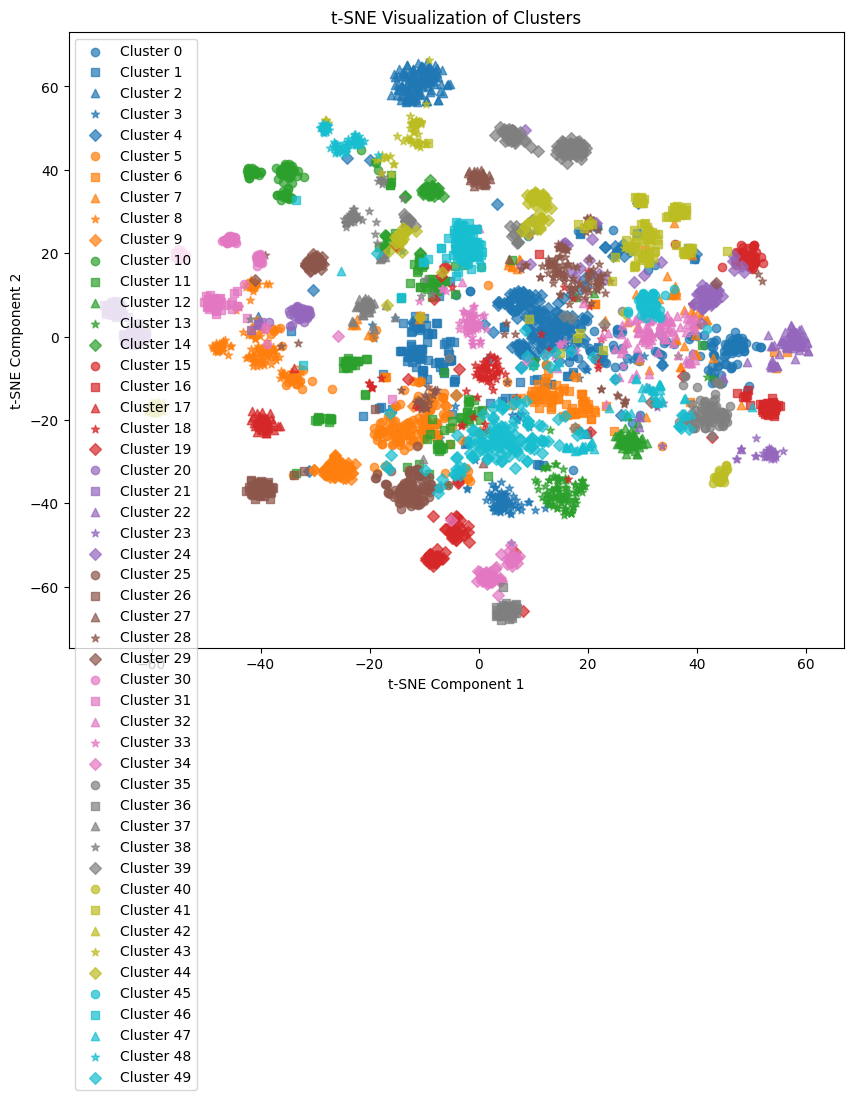

In [24]:
data = x_train
labels = clusters
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(data)

colormap = plt.get_cmap('tab10')  
markers = ['o', 's', '^', '*', 'D']

plt.figure(figsize=(10, 8))

for i, cluster_label in enumerate(np.unique(labels)):
    cluster_indices = np.where(labels == cluster_label)
    plt.scatter(
        embedded_data[cluster_indices, 0],
        embedded_data[cluster_indices, 1],
        label=f'Cluster {cluster_label}',
        alpha=0.7,
        marker=markers[i % len(markers)],
        color=colormap(i / len(np.unique(labels)))
    )

plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()
